In [62]:
import numpy as np


# activation function
def relu(inputs):
    return np.maximum(inputs, 0)

# output probability distribution function
def softmax(inputs):
    exp = np.exp(inputs)
    return exp/np.sum(exp, axis = 1, keepdims = True)

# loss
def cross_entropy(inputs, y):
    indices = np.argmax(y, axis = 1).astype(int)
    probability = inputs[np.arange(len(inputs)), indices] #inputs[0, indices]
    log = np.log(probability)
    loss = -1.0 * np.sum(log) / len(log)
    return loss

# L2 regularization
def L2_regularization(la, weight1, weight2):
    weight1_loss = 0.5 * la * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * la * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss

In [118]:
class Network:

    def __init__(self, 
                 num_nodes_in_layers, 
                 batch_size,
                 num_epochs,
                 learning_rate
                 ):

        self.num_nodes_in_layers = num_nodes_in_layers
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

        # build the network
        #         w1/b1    w2/b2   
        #784(inputs) ---> 20 ---> 10(output)
        #         x     z1  a1  z2  a2=y
        self.weight1 = np.random.normal(0, 1, [self.num_nodes_in_layers[0], self.num_nodes_in_layers[1]])
        self.bias1 = np.zeros((1, self.num_nodes_in_layers[1]))
        self.weight2 = np.random.normal(0, 1, [self.num_nodes_in_layers[1], self.num_nodes_in_layers[2]])
        self.bias2 = np.zeros((1, self.num_nodes_in_layers[2]))
        self.loss = []

    def train(self, inputs, labels):

        for epoch in range(self.num_epochs): # training begin
            iteration = 0
            while iteration < len(inputs):

                # batch input
                inputs_batch = inputs[iteration:iteration+self.batch_size]
                labels_batch = labels[iteration:iteration+self.batch_size]
                
                # forward pass
                z1 = np.dot(inputs_batch, self.weight1) + self.bias1
                a1 = relu(z1)
                z2 = np.dot(a1, self.weight2) + self.bias2
                y = softmax(z2)
                
                # calculate loss
                loss = cross_entropy(y, labels_batch)
                loss += L2_regularization(0.01, self.weight1, self.weight2)#lambda
                self.loss.append(loss)

                # backward pass
                delta_y = (y - labels_batch) / y.shape[0]
                delta_hidden_layer = np.dot(delta_y, self.weight2.T) 
                delta_hidden_layer[a1 <= 0] = 0 # derivatives of relu

                # backpropagation
                weight2_gradient = np.dot(a1.T, delta_y) # forward * backward
                bias2_gradient = np.sum(delta_y, axis = 0, keepdims = True)
            
                weight1_gradient = np.dot(inputs_batch.T, delta_hidden_layer)
                bias1_gradient = np.sum(delta_hidden_layer, axis = 0, keepdims = True)

                # L2 regularization
                weight2_gradient += 0.01 * self.weight2
                weight1_gradient += 0.01 * self.weight1

                # stochastic gradient descent
                self.weight1 -= self.learning_rate * weight1_gradient #update weight and bias
                self.bias1 -= self.learning_rate * bias1_gradient
                self.weight2 -= self.learning_rate * weight2_gradient
                self.bias2 -= self.learning_rate * bias2_gradient

                iteration += self.batch_size
                
            print('=== Epoch: %d/%d\tLoss: %.2f ===' %(epoch+1, self.num_epochs, loss))

    def test(self, inputs, labels):
        input_layer = np.dot(inputs, self.weight1)
        hidden_layer = relu(input_layer + self.bias1)
        scores = np.dot(hidden_layer, self.weight2) + self.bias2
        probs = softmax(scores)
        acc = float(np.sum(np.argmax(probs, 1) == labels)) / float(len(labels))
        print('test acc %.2f' % (acc*100))
        
    def predict(self, input):
        input_layer = np.dot(input, self.weight1)
        hidden_layer = relu(input_layer + self.bias1)
        scores = np.dot(hidden_layer, self.weight2) + self.bias2
        pred = softmax(scores)
        pred[np.where(pred==np.max(pred))] = 1
        pred[np.where(pred!=np.max(pred))] = 0
        return pred.flatten()

In [155]:
import mnist


# load data
num_classes = 10
train_images = mnist.train_images() #[60000, 28, 28]
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

print("Training...")

# data processing
X_train = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2]).astype('float32') #flatten 28x28 to 784x1 vectors, [60000, 784]
x_train = X_train / 255 #normalization
y_train = np.eye(num_classes)[train_labels] #convert label to one-hot

X_test = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2]).astype('float32') #flatten 28x28 to 784x1 vectors, [60000, 784]
x_test = X_test / 255 #normalization
y_test = test_labels

net = Network(
                 num_nodes_in_layers = [784, 20, 10], 
                 batch_size = 1,
                 num_epochs = 5,
                 learning_rate = 0.001
             )

net.train(x_train, y_train)


print("Testing...")
net.test(x_test, y_test)

Training...
=== Epoch: 1/5	Loss: 25.44 ===
=== Epoch: 2/5	Loss: 8.08 ===
=== Epoch: 3/5	Loss: 2.82 ===
=== Epoch: 4/5	Loss: 1.34 ===
=== Epoch: 5/5	Loss: 0.89 ===
Testing...
test acc 91.77


image 1 is : 7
image 2 is : 2
image 3 is : 1
image 4 is : 0


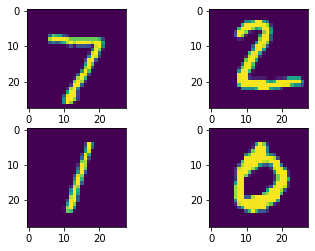

In [157]:
import matplotlib.pyplot as plt
test_images = mnist.test_images()

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(test_images[0])
axarr[0,1].imshow(test_images[1])
axarr[1,0].imshow(test_images[2])
axarr[1,1].imshow(test_images[3])

for i in range(4):
    test_image = test_images[i]/255.0
    test_image = net.predict(test_image.reshape(784))
    print('image %d is : %d' % (i+1, test_image.argmax()))